# Libraries

# **Fewshot Learning Presentation**



 *Piyush Shukla (22ucs150)*

  *Parth Sarthi Dixit (22ucs148)*





In [ ]:
from google.colab import files
import os, random, zipfile 
import numpy as np
from PIL import Image 
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 
from torchvision import transforms, models 
import matplotlib.pyplot as plt 

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Dataset Upload

In [ ]:

uploaded = files.upload()
for fname in uploaded:
    if fname.endswith('.zip'):
        with zipfile.ZipFile(fname, 'r') as z:
            z.extractall('/content/omniglot/')
        print(f"Extracted {fname}")


train_root = '/content/omniglot/images_background/images_background'
test_root  = '/content/omniglot/images_evaluation/images_evaluation'


Saving archive.zip to archive.zip
Extracted archive.zip


# Dataset creation

In [ ]:
class OmniglotDataset(Dataset):
    def __init__(self, root_dir, num_way, num_shot, num_query, episodes_per_epoch, transform=None):
        self.characters = []
        self.imgs = {}
        self.num_way = num_way
        self.num_shot = num_shot
        self.num_query = num_query
        self.episodes_per_epoch = episodes_per_epoch
        self.transform = transform

        # Build mapping
        for alphabet in os.listdir(root_dir):
            alphabet_path = os.path.join(root_dir, alphabet)
            if os.path.isdir(alphabet_path):
                for ch in os.listdir(alphabet_path):
                    c_path = os.path.join(alphabet_path, ch)
                    if os.path.isdir(c_path):
                        img_files = [os.path.join(c_path,f) for f in os.listdir(c_path) if f.endswith('.png')]
                        if len(img_files) >= (num_shot + num_query):
                            self.characters.append(c_path)
                            self.imgs[c_path] = img_files
    def __len__(self):
        return self.episodes_per_epoch

    def __getitem__(self, idx):

        # Sample num_ways classes
        selected_claases = random.sample(self.characters, self.num_way)
        support_x, support_y, query_x, query_y = [], [], [], []


        for class_index, c in enumerate(selected_claases):
            paths = self.imgs[c]

            # Sample n_shot + n_query classes
            chosen = random.sample(paths, self.num_shot + self.num_query)

            # Put support paths in support and query paths in query
            sup_paths = chosen[:self.num_shot]
            qry_paths = chosen[self.num_shot:]

            # Support and query images
            for p in sup_paths:.
                img = Image.open(p).convert('L')
                if self.transform: img = self.transform(img)
                support_x.append(img); support_y.append(class_index)
            for p in qry_paths:
                img = Image.open(p).convert('L')
                if self.transform: img = self.transform(img)
                query_x.append(img); query_y.append(class_index)

        
        support_x = torch.stack(support_x)       
        support_y = torch.tensor(support_y)     
        query_x   = torch.stack(query_x)        
        query_y   = torch.tensor(query_y)       
        return support_x, support_y, query_x, query_y


# Siamese Network

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_dim=256):
        super().__init__()

        self.backbone = models.resnet34(weights=None)
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone.fc = nn.Identity()
        self.fc = nn.Sequential(nn.Linear(512, embedding_dim), nn.ReLU(inplace=True))

    def forward_one(self, x):
        return self.fc(self.backbone(x))

    def forward(self, support_x, query_x, num_way, num_shot):
        # Twin Siamese network for support and query
        sup_emb = self.forward_one(support_x)
        qry_emb = self.forward_one(query_x)
        D = sup_emb.shape[-1]


        # Calculate mean of embeddings over the num_shots
        mean_emb = sup_emb.view(num_way, num_shot, D).mean(dim=1)
        dists = (qry_emb.unsqueeze(1) - mean_emb.unsqueeze(0)).pow(2).sum(dim=2)
        logits = -dists
        return logits  

# Training

In [ ]:
def train_episode(model, loader, optimizer, criterion, num_way, num_shot, device):
    model.train()
    total_loss, total_acc = 0.0, 0.0
    for support_x, support_y, query_x, query_y in loader:   #[1, N·K, C, H, W]
        support_x, support_y = support_x.squeeze(0).to(device), support_y.squeeze(0).to(device)  #[N·K, C, H, W]
        query_x, query_y     = query_x.squeeze(0).to(device),   query_y.squeeze(0).to(device)

        logits = model(support_x, query_x, num_way, num_shot)  
        loss = criterion(logits, query_y)    
        preds = torch.argmax(logits, dim=1)   
        acc = (preds == query_y).float().mean()  

        optimizer.zero_grad() 
        loss.backward()  
        optimizer.step()  
        total_loss += loss.item(); total_acc += acc.item()
    return total_loss/len(loader), total_acc/len(loader)


def test_episode(model, loader, criterion, num_way, num_shot, device):
    model.eval()
    total_loss, total_acc = 0.0, 0.0
    with torch.no_grad():
        for support_x, support_y, query_x, query_y in loader:
            support_x, support_y = support_x.squeeze(0).to(device), support_y.squeeze(0).to(device)
            query_x, query_y     = query_x.squeeze(0).to(device),   query_y.squeeze(0).to(device)

            logits = model(support_x, query_x, num_way, num_shot)
            loss = criterion(logits, query_y)
            preds = torch.argmax(logits, dim=1)
            acc = (preds == query_y).float().mean()
            total_loss += loss.item(); total_acc += acc.item()
    return total_loss/len(loader), total_acc/len(loader)


Epoch 1: Train Acc 73.82% | Test Acc 73.10%
Epoch 2: Train Acc 82.86% | Test Acc 78.60%
Epoch 3: Train Acc 87.62% | Test Acc 81.30%
Epoch 4: Train Acc 88.88% | Test Acc 85.60%
Epoch 5: Train Acc 91.98% | Test Acc 78.20%
Epoch 6: Train Acc 92.24% | Test Acc 85.30%
Epoch 7: Train Acc 92.32% | Test Acc 89.30%
Epoch 8: Train Acc 92.10% | Test Acc 88.00%
Epoch 9: Train Acc 90.44% | Test Acc 85.20%
Epoch 10: Train Acc 91.22% | Test Acc 82.90%
Epoch 11: Train Acc 91.58% | Test Acc 84.70%
Epoch 12: Train Acc 91.32% | Test Acc 84.10%
Epoch 13: Train Acc 92.46% | Test Acc 87.00%
Epoch 14: Train Acc 93.34% | Test Acc 86.00%
Epoch 15: Train Acc 94.94% | Test Acc 85.90%
Epoch 16: Train Acc 92.74% | Test Acc 87.20%
Epoch 17: Train Acc 93.14% | Test Acc 85.80%
Epoch 18: Train Acc 93.98% | Test Acc 83.80%
Epoch 19: Train Acc 94.76% | Test Acc 88.00%
Epoch 20: Train Acc 94.26% | Test Acc 88.30%


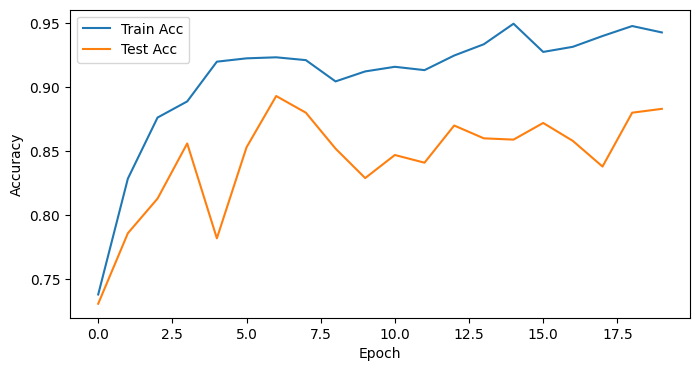

In [ ]:
    num_way   = 5
    num_shot  = 1
    num_query = 1
    train_eps = 1000
    test_eps  = 200
    embed_dim = 256
    lr        = 1e-3
    epochs    = 20
    batch_sz  = 1

    transform = transforms.Compose([
        transforms.Resize((105,105)), transforms.ToTensor()
    ])

    train_ds = OmniglotDataset(train_root, num_way, num_shot, num_query, train_eps, transform)
    test_ds  = OmniglotDataset(test_root,  num_way, num_shot, num_query, test_eps,  transform)
    train_loader = DataLoader(train_ds, batch_size=batch_sz, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_sz, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SiameseNetwork(embed_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[]}
    for ep in range(1, epochs+1):
        tl, ta = train_episode(model, train_loader, optimizer, criterion, num_way, num_shot, device)
        vl, va = test_episode( model, test_loader,  criterion, num_way, num_shot, device)
        history['train_loss'].append(tl);
        history['train_acc'].append(ta);
        history['test_loss'].append(vl);
        history['test_acc'].append(va);
        print(f"Epoch {ep}: Train Acc {ta*100:.2f}% | Test Acc {va*100:.2f}%")

    # Plotting accuracy curves
    plt.figure(figsize=(8,4))
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['test_acc'],  label='Test Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

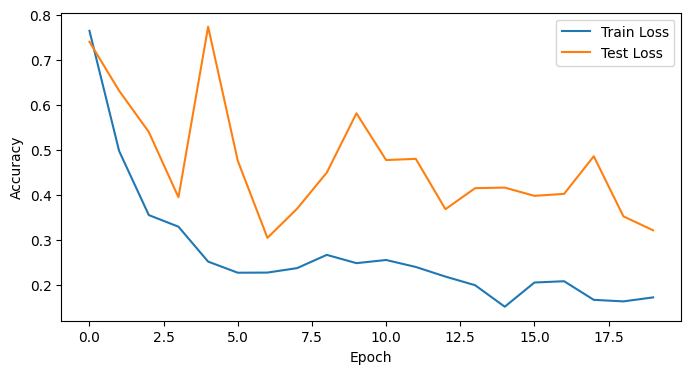

In [ ]:
    plt.figure(figsize=(8,4))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['test_loss'],  label='Test Loss')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

# Testing on images

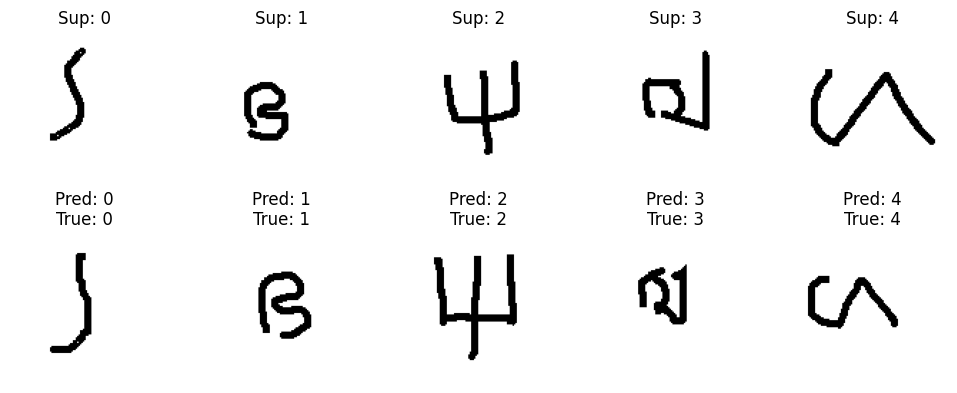

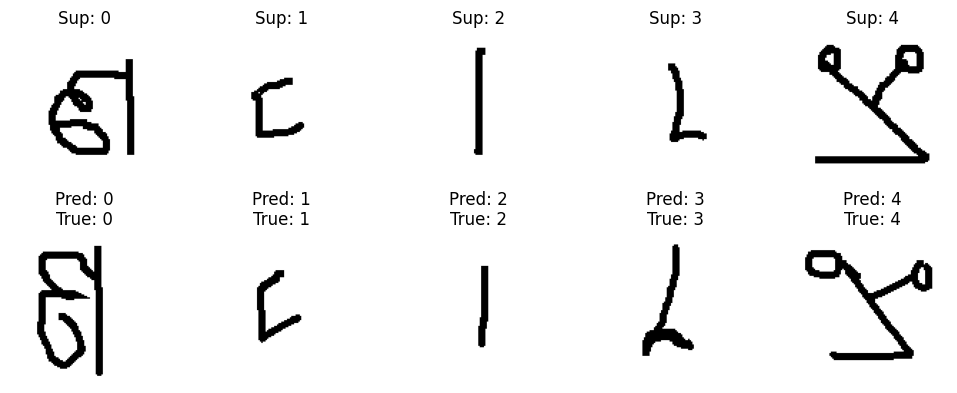

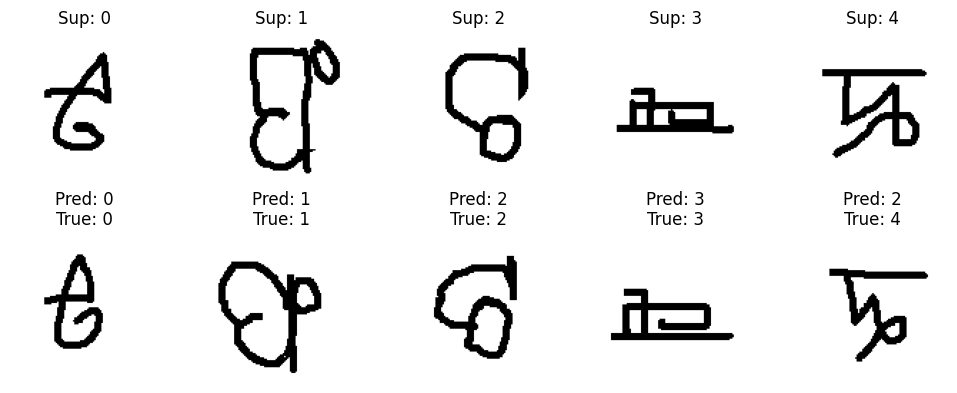

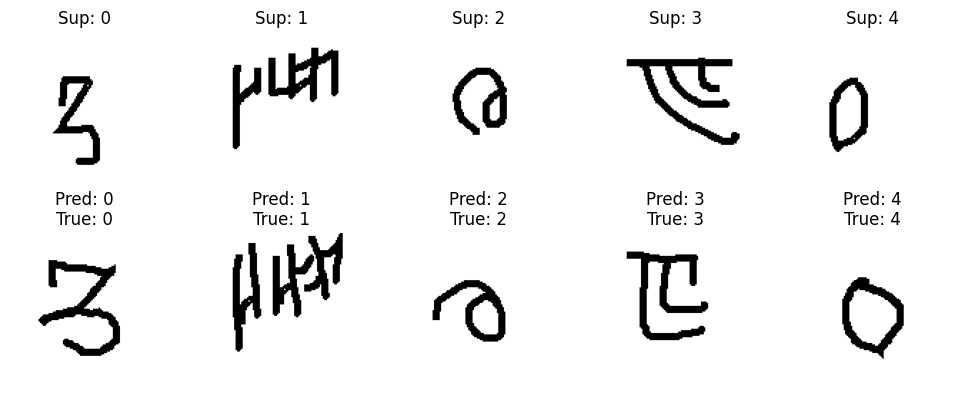

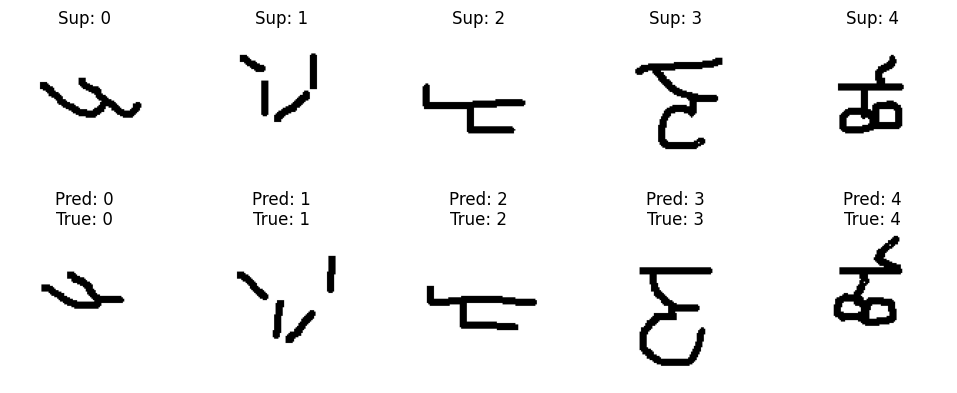

In [ ]:
    def visual_test(model, loader, num_way, num_shot, device, n_visuals=5):
        model.eval()
        with torch.no_grad():
            count = 0
            for support_x, support_y, query_x, query_y in loader:
                if count >= n_visuals: break
                count += 1
                # remove batch dim
                support_x, support_y = support_x.squeeze(0).to(device), support_y.squeeze(0).to(device)
                query_x,   query_y   = query_x.squeeze(0).to(device),   query_y.squeeze(0).to(device)
                logits = model(support_x, query_x, num_way, num_shot)
                preds = torch.argmax(logits, dim=1)

                
                fig, axes = plt.subplots(2, num_way, figsize=(num_way*2, 4))
               
                for i in range(num_way):
                    ax = axes[0, i]
                    img = support_x[i].cpu().squeeze()
                    ax.imshow(img, cmap='gray')
                    ax.set_title(f"Sup: {support_y[i].item()}")
                    ax.axis('off')
                
                for i in range(num_way):
                    ax = axes[1, i]
                    img = query_x[i].cpu().squeeze()
                    ax.imshow(img, cmap='gray')
                    ax.set_title(f"Pred: {preds[i].item()}\nTrue: {query_y[i].item()}")
                    ax.axis('off')
                plt.tight_layout()
                plt.show()

   
    visual_test(model, test_loader, num_way, num_shot, device, n_visuals=5)